<a href="https://colab.research.google.com/github/nahumsa/Cellular-Automata/blob/master/Forest%20Fires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forest Fires

# 1) Introduction

Forest fires model was introduced by B. Drossel and F. Schwabl on the paper [Self-Organized Critical Forest-Fire Model](http://rocs.hu-berlin.de/complex_sys_2016/resources/Seminarpapers/Forrest_Fire_1992.pdf). As a model that has a self-organized critical state. 

The code is based on the book [Natural Complexity](https://press.princeton.edu/books/hardcover/9780691176840/natural-complexity) by Paul Charbonneau.

The surprising thing is that such a simple model has a rather complex behaviour.

# 2) Forest Fires Model 

## 2.1) Standard Case
This model consists of a 2D probabilistic Celullar Automata on a cartesian lattice. It has three possible states: Active, representing burning trees, Inactive, representing trees, and Empty, representing burned trees. Time evolves discretly and we start with an empty lattice. The rules for evolution are: 

- **Rule 1**: An empty node can be occupied with probability $P_G$. $\rightarrow$ This is a stochastic rule that represent when a tree grows.

- **Rule 2**: An inactive node(Trees) is activated with probability $P_L$. $\rightarrow$ This represents when a tree is struck by lightning and begins to burn.

- **Rule 3**: An inactive node becomes active if one or more of its neighbors was active at the preceding iteration. $\rightarrow$ This represents when the fire spreads from a burning tree.

- **Rule 4**: Active nodes becomes empty at the following iteration. $\rightarrow$ This represents when the tree is burned.

This seems like a simple model coming from ecology, but the evolution depends strongly on the growth probability ($P_G$) and the "lightning" probability ($P_L$), showing a complex behaviour.

Let's implement this on python.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
#Helper functions from mitdeeplearning
import time
from IPython import display as ipythondisplay
from string import Formatter
import matplotlib.pyplot as plt

class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None):
    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale
    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
        if len(data) == 2:
          plt.plot(data[0], label='Trees')
          plt.plot(data[1], label='Fires')
          plt.legend()
        else:
          plt.plot(data)
        
      elif self.scale == 'semilogx':
        if len(data) == 2:
          plt.plot(data[0], label='Trees')
          plt.plot(data[1], label='Fires')
          plt.legend()
        else:
          plt.plot(data)

      elif self.scale == 'semilogy':
        if len(data) == 2:
          plt.plot(data[0], label='Trees')
          plt.plot(data[1], label='Fires')
          plt.legend()
        else:
          plt.plot(data)

      elif self.scale == 'loglog':
        if len(data) == 2:
          plt.plot(data[0], label='Trees')
          plt.plot(data[1], label='Fires')
          plt.legend()
        else:
          plt.plot(data)
      
      else:
        raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()

In [86]:
def forest_fires(N, p_g, p_l, n_iter, plotter=None, progress=False):

  dx = np.array([-1, 0, 1, 1, 1, 0, -1, -1])
  dy = np.array([-1, -1, -1, 0, 1, 1, 1, 0])

  grid = np.zeros([N+2, N+2], dtype='int')
  trees = 0
  n_trees = []
  n_fires = []

  if progress:
    iterations = tqdm(range(n_iter))

  else:
    iterations = range(n_iter)

  for iterate in iterations:
    update = np.zeros([N+2, N+2], dtype='int')
    burn = 0

    for i in range(1, N+1):
      for j in range(1, N+1):
        
        # Check if there is a tree
        if grid[i,j] == 1:

          # Check if there is a burnin neighboring tree
          if 2 in grid[i+dx[:], j+dy[:]]:
            update[i,j] = 1
            burn += 1

          # Check if there is a lightning strike
          if np.random.uniform() < p_l:
            update[i,j] = 1
            burn += 1

        # Remove burned trees
        if grid[i,j] == 2:
          update[i,j] -= 2
          trees -= 1
        
        # Check if a new tree grows

        if grid[i,j] == 0:
          if np.random.uniform() < p_g:
            update[i,j] += 1
            trees += 1
      
    n_trees.append(trees)
    n_fires.append(burn)
    
    if plotter:
      plotter.plot([n_trees,n_fires])
    
    # Update the grid
    grid += update

    #print(f'Iteration: {iterate} | Trees: {trees} | burned {burn}')
  return n_trees, n_fires  

### 2.1.1) Generating the time series

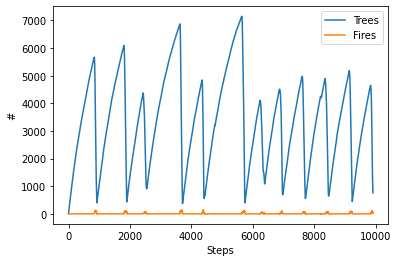

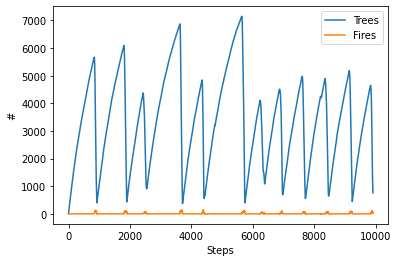

In [87]:
# Parameters
N = 100
p_g = 1e-3
p_l = 1e-6
n_iter = int(1e4)
progress = True
plotter = PeriodicPlotter(sec=5, xlabel='Steps', ylabel='#')

series_trees, series_fires = forest_fires(N, p_g, p_l, n_iter,plotter= plotter)

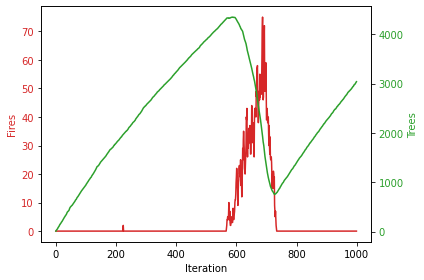

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Fires', color=color)
ax1.plot(series_fires, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Trees', color=color)  # we already handled the x-label with ax1
ax2.plot(series_trees, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### 2.1.2) Extracting Parameters from the time series

In [47]:
def extract_timeseries(series, N=100):
  """ Extract parameters for the time series
      E: Total number of trees burned;
      P: Peak number of trees burned at one fire;
      T: Fire duration;
  """
  n_max_av = N*N
  E_av = [] #np.zeros(n_max_av)
  P_av = [] #np.zeros(n_max_av)
  T_av = [] #np.zeros(n_max_av)
  n_iter = len(series)
  tsum = 0.
  av_max = 0.
  n_av = 0
  for iterate in range(1,n_iter):

    # Check if the fire started
    if series[iterate] > 0. and series[iterate - 1] == 0.:
      
      # Reset variables
      tsum, av_max = 0., 0.
      
      #Log the time that the fire started
      fire_start = iterate
      
      if n_av == n_max_av -1:
        print('Too many fires')
        break
      
      # Add a count for the number of fires
      n_av += 1
    
    tsum += series[iterate]
    
    # Log peak
    if series[iterate] > av_max:
      av_max = series[iterate]
    
    # Check if the fire ended
    if series[iterate] <= 0. and series[iterate - 1] > 0.:
      # Number of trees burned on the fire
      E_av.append(tsum) #[n_av] = tsum
      
      #Fire peak
      P_av.append(av_max) #[n_av] = av_max
      
      #Fire duration
      T_av.append(fire_start) #[n_av] = iterate - fire_start 

  return n_av, E_av, P_av, T_av

In [48]:
N_fires, E_av, P_av, T_av = extract_timeseries(series_fires)
print(f'Number of fires: {N_fires}')

Number of fires: 33


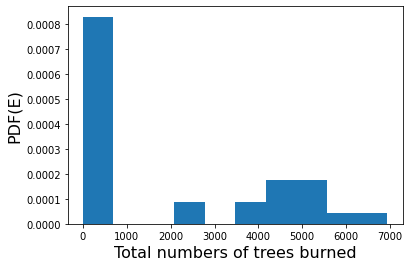

In [49]:
plt.hist(E_av, density=True)
plt.xlabel('Total numbers of trees burned', size=16)
plt.ylabel('PDF(E)', size=16)
plt.show()

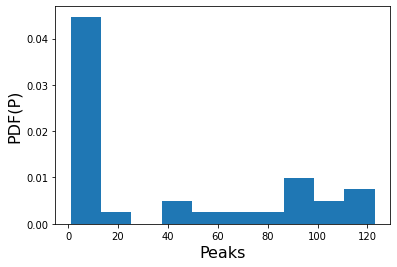

In [52]:
plt.hist(P_av, density=True)
plt.xlabel('Peaks', size=16)
plt.ylabel('PDF(P)', size=16)
plt.show()

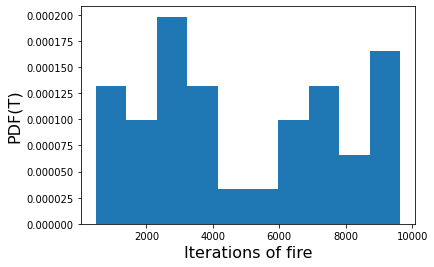

In [53]:
plt.hist(T_av, density=True)
plt.xlabel('Iterations of fire', size=16)
plt.ylabel('PDF(T)', size=16)
plt.show()

### 2.1.3) Generating time series for $p_g = 10^{-4}$ and $p_f = 10^{-6}$

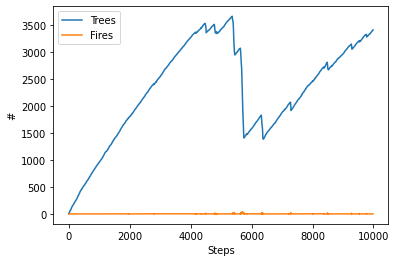

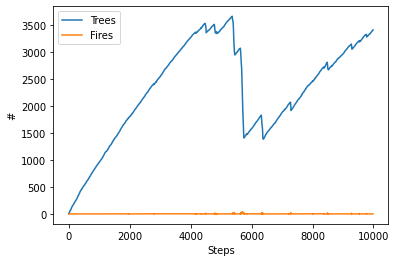

In [74]:
# Parameters
N = 100
p_g = 1e-4
p_l = 1e-6
n_iter = int(1e4)
progress = True
plotter = PeriodicPlotter(sec=5, xlabel='Steps', ylabel='#')

series_trees, series_fires = forest_fires(N, p_g, p_l, n_iter,plotter= plotter)

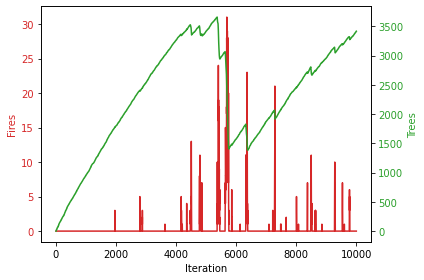

In [75]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Fires', color=color)
ax1.plot(series_fires, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Trees', color=color)  # we already handled the x-label with ax1
ax2.plot(series_trees, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### 2.1.4) Extracting parameters

In [76]:
N_fires, E_av, P_av, T_av = extract_timeseries(series_fires)
print(f'Number of fires: {N_fires}')

Number of fires: 32


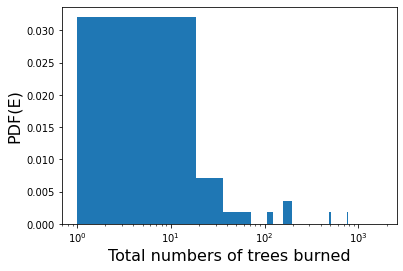

In [84]:
plt.hist(E_av, bins=100, density=True)
plt.xlabel('Total numbers of trees burned', size=16)
plt.xscale('log')
plt.ylabel('PDF(E)', size=16)
plt.show()

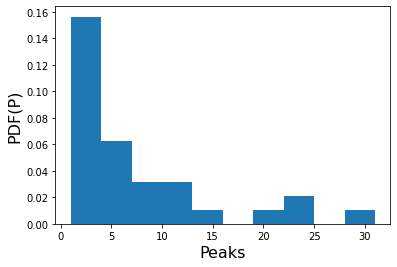

In [78]:
plt.hist(P_av, density=True)
plt.xlabel('Peaks', size=16)
plt.ylabel('PDF(P)', size=16)
plt.show()

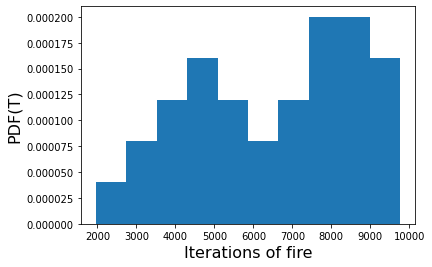

In [79]:
plt.hist(T_av, density=True)
plt.xlabel('Iterations of fire', size=16)
plt.ylabel('PDF(T)', size=16)
plt.show()

## 2.2) Stop-and-go

There is no possibility to grow a tree when there are trees burning

In [54]:
def forest_fires(N, p_g, p_l, n_iter, plotter=None, progress=False):

  dx = np.array([-1, 0, 1, 1, 1, 0, -1, -1])
  dy = np.array([-1, -1, -1, 0, 1, 1, 1, 0])

  grid = np.zeros([N+2, N+2], dtype='int')
  trees = 0
  n_trees = []
  n_fires = []

  if progress:
    iterations = tqdm(range(n_iter))

  else:
    iterations = range(n_iter)

  for iterate in iterations:
    update = np.zeros([N+2, N+2], dtype='int')
    burn = 0

    for i in range(1, N+1):
      for j in range(1, N+1):
        
        # Check if there is a tree
        if grid[i,j] == 1:

          # Check if there is a burnin neighboring tree
          if 2 in grid[i+dx[:], j+dy[:]]:
            update[i,j] = 1
            burn += 1

          # Check if there is a lightning strike
          if np.random.uniform() < p_l:
            update[i,j] = 1
            burn += 1

        # Remove burned trees
        if grid[i,j] == 2:
          update[i,j] -= 2
          trees -= 1
        
        # Check if a new tree grows        
        if (not 2 in grid) and grid[i,j] == 0:
          if np.random.uniform() < p_g:
            update[i,j] += 1
            trees += 1
      
    n_trees.append(trees)
    n_fires.append(burn)
    
    if plotter:
      plotter.plot([n_trees,n_fires])
    
    # Update the grid
    grid += update

    #print(f'Iteration: {iterate} | Trees: {trees} | burned {burn}')
  return n_trees, n_fires  

### 2.2.1) Generating the time series

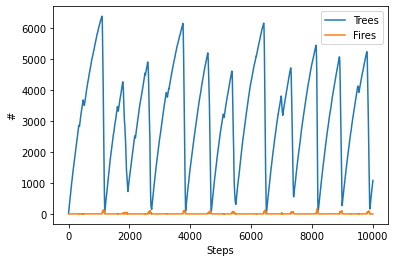

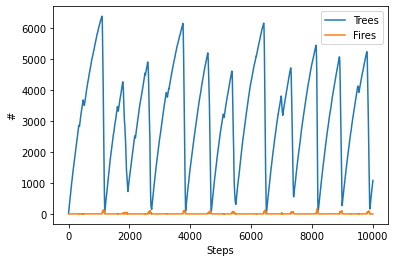

In [57]:
# Parameters
N = 100
p_g = 1e-3
p_l = 1e-6
n_iter = int(1e4)
progress = True
plotter = PeriodicPlotter(sec=5, xlabel='Steps', ylabel='#')

series_trees, series_fires = forest_fires(N, p_g, p_l, n_iter,plotter= plotter)

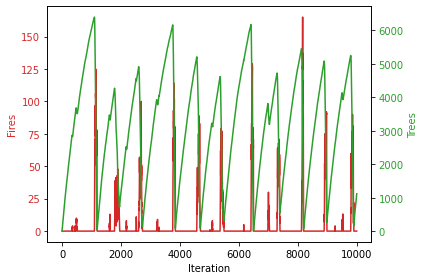

In [59]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Fires', color=color)
ax1.plot(series_fires, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Trees', color=color)  # we already handled the x-label with ax1
ax2.plot(series_trees, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### 2.2.2) Extracting parameters from the Time Series

In [60]:
N_fires, E_av, P_av, T_av = extract_timeseries(series_fires)
print(f'Number of fires: {N_fires}')

Number of fires: 25


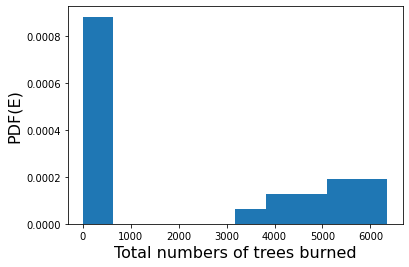

In [61]:
plt.hist(E_av, density=True)
plt.xlabel('Total numbers of trees burned', size=16)
plt.ylabel('PDF(E)', size=16)
plt.show()

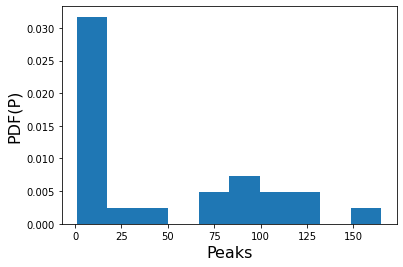

In [62]:
plt.hist(P_av, density=True)
plt.xlabel('Peaks', size=16)
plt.ylabel('PDF(P)', size=16)
plt.show()

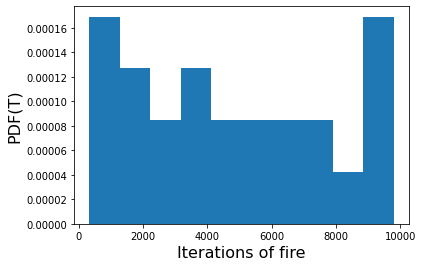

In [63]:
plt.hist(T_av, density=True)
plt.xlabel('Iterations of fire', size=16)
plt.ylabel('PDF(T)', size=16)
plt.show()

## 2.3) Modifying neighboring conditions

We modify the neighboring conditions in order to propagate only on the 4 neighbors.

In [ ]:
def forest_fires(N, p_g, p_l, n_iter, plotter=None, progress=False):

  dx = np.array([0,0,1,-1])
  dy = np.array([1,-1,1,-1])

  grid = np.zeros([N+2, N+2], dtype='int')
  trees = 0
  n_trees = []
  n_fires = []

  if progress:
    iterations = tqdm(range(n_iter))

  else:
    iterations = range(n_iter)

  for iterate in iterations:
    update = np.zeros([N+2, N+2], dtype='int')
    burn = 0

    for i in range(1, N+1):
      for j in range(1, N+1):
        
        # Check if there is a tree
        if grid[i,j] == 1:

          # Check if there is a burnin neighboring tree
          if 2 in grid[i+dx[:], j+dy[:]]:
            update[i,j] = 1
            burn += 1

          # Check if there is a lightning strike
          if np.random.uniform() < p_l:
            update[i,j] = 1
            burn += 1

        # Remove burned trees
        if grid[i,j] == 2:
          update[i,j] -= 2
          trees -= 1
        
        # Check if a new tree grows

        if grid[i,j] == 0:
          if np.random.uniform() < p_g:
            update[i,j] += 1
            trees += 1
      
    n_trees.append(trees)
    n_fires.append(burn)
    
    if plotter:
      plotter.plot([n_trees,n_fires])
    
    # Update the grid
    grid += update

    #print(f'Iteration: {iterate} | Trees: {trees} | burned {burn}')
  return n_trees, n_fires  

### 2.3.1) Generating the time series

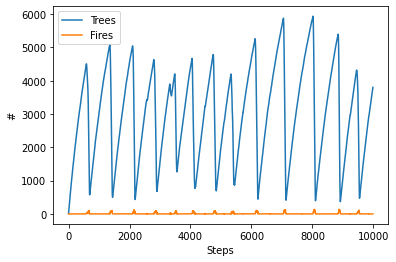

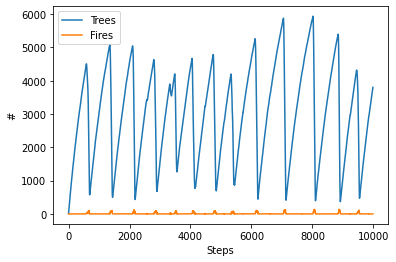

In [88]:
# Parameters
N = 100
p_g = 1e-3
p_l = 1e-6
n_iter = int(1e4)
progress = True
plotter = PeriodicPlotter(sec=5, xlabel='Steps', ylabel='#')

series_trees, series_fires = forest_fires(N, p_g, p_l, n_iter,plotter= plotter)

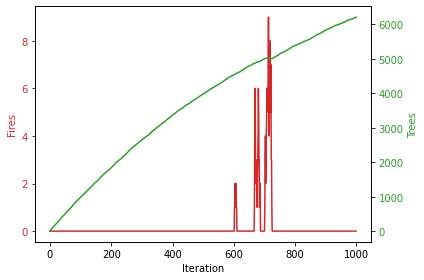

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Fires', color=color)
ax1.plot(series_fires, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Trees', color=color)  # we already handled the x-label with ax1
ax2.plot(series_trees, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### 2.3.2) Generating parameters from the time series

In [ ]:
N_fires, E_av, P_av, T_av = extract_timeseries(series_fires)
print(f'Number of fires: {N_fires}')

Number of fires: 33


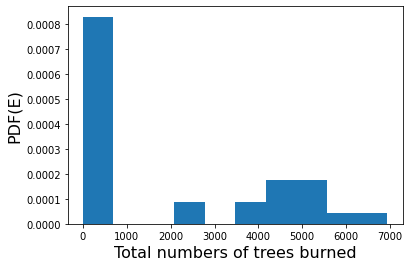

In [ ]:
plt.hist(E_av, density=True)
plt.xlabel('Total numbers of trees burned', size=16)
plt.ylabel('PDF(E)', size=16)
plt.show()

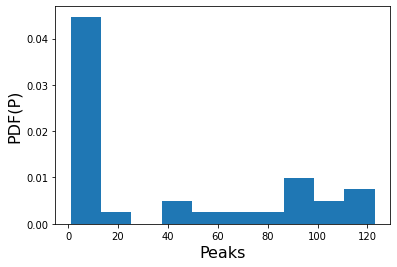

In [ ]:
plt.hist(P_av, density=True)
plt.xlabel('Peaks', size=16)
plt.ylabel('PDF(P)', size=16)
plt.show()

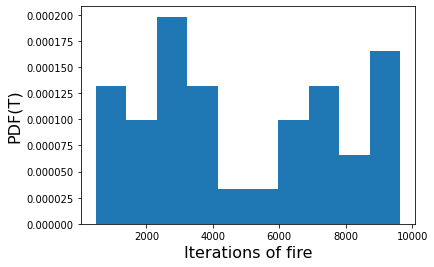

In [ ]:
plt.hist(T_av, density=True)
plt.xlabel('Iterations of fire', size=16)
plt.ylabel('PDF(T)', size=16)
plt.show()

## 2.4) Modifying the growth probability

Let's modify the growth probability to the probability of growing a tree depends linearly with the number of trees

In [64]:
def linear_forest_fires(N, p_g, p_l, n_iter, plotter=None, progress=False):

  dx = np.array([-1, 0, 1, 1, 1, 0, -1, -1])
  dy = np.array([-1, -1, -1, 0, 1, 1, 1, 0])

  grid = np.zeros([N+2, N+2], dtype='int')
  trees = 0
  n_trees = []
  n_fires = []

  if progress:
    iterations = tqdm(range(n_iter))

  else:
    iterations = range(n_iter)

  for iterate in iterations:
    update = np.zeros([N+2, N+2], dtype='int')
    burn = 0

    for i in range(1, N+1):
      for j in range(1, N+1):
        
        # Check if there is a tree
        if grid[i,j] == 1:

          # Check if there is a burnin neighboring tree
          if 2 in grid[i+dx[:], j+dy[:]]:
            update[i,j] = 1
            burn += 1

          # Check if there is a lightning strike
          if np.random.uniform() < p_l:
            update[i,j] = 1
            burn += 1

        # Remove burned trees
        if grid[i,j] == 2:
          update[i,j] -= 2
          trees -= 1
        
        # Check if a new tree grows

        if grid[i,j] == 0:
          if np.random.uniform() < p_g*(1 + trees):
            update[i,j] += 1
            trees += 1
      
    n_trees.append(trees)
    n_fires.append(burn)
    
    if plotter:
      plotter.plot([n_trees,n_fires])
    
    # Update the grid
    grid += update

    #print(f'Iteration: {iterate} | Trees: {trees} | burned {burn}')
  return n_trees, n_fires  

### 2.4.1) Generating the time series

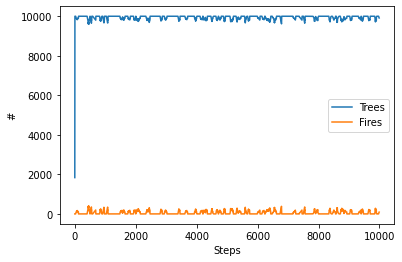

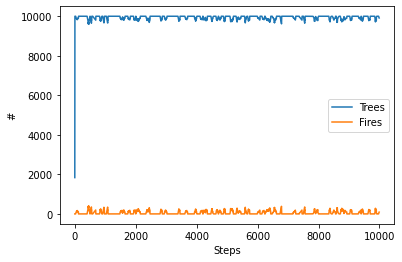

In [66]:
# Parameters
N = 100
p_g = 1e-3
p_l = 1e-6
n_iter = int(1e4)
progress = True
plotter = PeriodicPlotter(sec=5, xlabel='Steps', ylabel='#')

series_trees, series_fires = linear_forest_fires(N, p_g, p_l, n_iter, plotter=plotter)

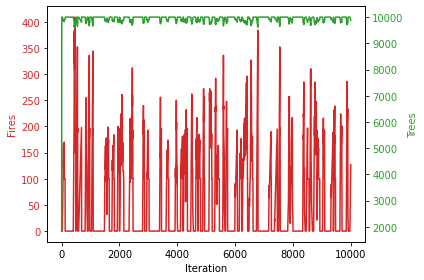

In [67]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Fires', color=color)
ax1.plot(series_fires, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Trees', color=color)  # we already handled the x-label with ax1
ax2.plot(series_trees, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### 2.4.2) Generating parameters from the time series

In [68]:
N_fires, E_av, P_av, T_av = extract_timeseries(series_fires)
print(f'Number of fires: {N_fires}')

Number of fires: 46


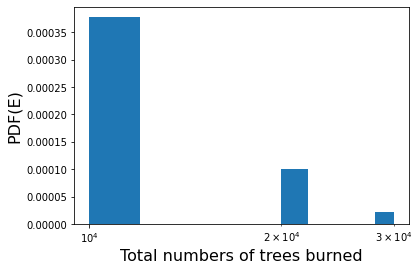

In [72]:
plt.hist(E_av, density=True)
plt.xlabel('Total numbers of trees burned', size=16)
plt.xscale('log')
plt.ylabel('PDF(E)', size=16)
plt.show()

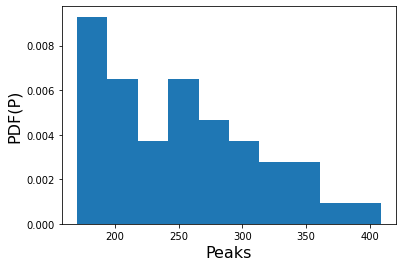

In [70]:
plt.hist(P_av, density=True)
plt.xlabel('Peaks', size=16)
plt.ylabel('PDF(P)', size=16)
plt.show()

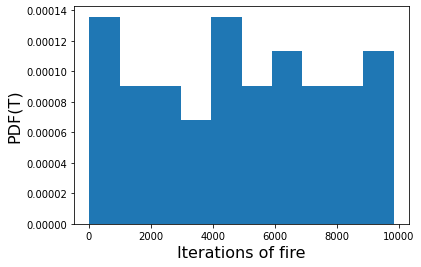

In [71]:
plt.hist(T_av, density=True)
plt.xlabel('Iterations of fire', size=16)
plt.ylabel('PDF(T)', size=16)
plt.show()

## 2.5) Adding a High probability to grow on the vicinity of the tree

In [ ]:
def forest_fires(N, p_g,p_g2, p_l, n_iter, plotter=None, progress=False):

  dx = np.array([-1, 0, 1, 1, 1, 0, -1, -1])
  dy = np.array([-1, -1, -1, 0, 1, 1, 1, 0])

  grid = np.zeros([N+2, N+2], dtype='int')
  trees = 0
  n_trees = []
  n_fires = []

  if progress:
    iterations = tqdm(range(n_iter))

  else:
    iterations = range(n_iter)

  for iterate in iterations:
    update = np.zeros([N+2, N+2], dtype='int')
    burn = 0

    for i in range(1, N+1):
      for j in range(1, N+1):
        
        # Check if there is a tree
        if grid[i,j] == 1:

          # Check if there is a burnin neighboring tree
          if 2 in grid[i+dx[:], j+dy[:]]:
            update[i,j] = 1
            burn += 1

          # Check if there is an empty space 
          if 0 in grid[i+dx[:], j+dy[:]]:
            for x,y in zip(dx,dy):              
              if np.random.uniform() < p_g2:
                update[x,y] += 1
                trees += 1


          # Check if there is a lightning strike
          if np.random.uniform() < p_l:
            update[i,j] = 1
            burn += 1
          
          
        # Remove burned trees
        if grid[i,j] == 2:
          update[i,j] -= 2
          trees -= 1
        
        # Check if a new tree grows

        if grid[i,j] == 0:
          if np.random.uniform() < p_g:
            update[i,j] += 1
            trees += 1
      
    n_trees.append(trees)
    n_fires.append(burn)
    
    if plotter:
      plotter.plot([n_trees,n_fires])
    
    # Update the grid
    grid += update

    #print(f'Iteration: {iterate} | Trees: {trees} | burned {burn}')
  return n_trees, n_fires  

### 2.5.1) Generating the time series

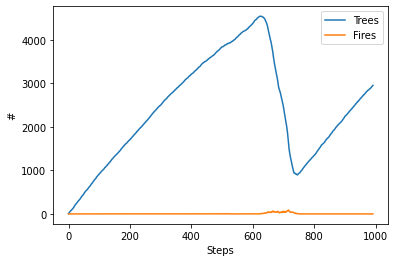

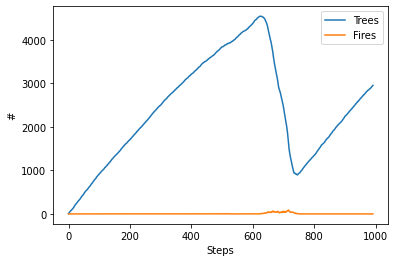

In [ ]:
# Parameters
N = 100
p_g = 1e-3
p_l = 1e-6
n_iter = int(1e3)
progress = True
plotter = PeriodicPlotter(sec=2, xlabel='Steps', ylabel='#')

series_trees, series_fires = forest_fires(N, p_g, 1e-5, p_l, n_iter, plotter=plotter)

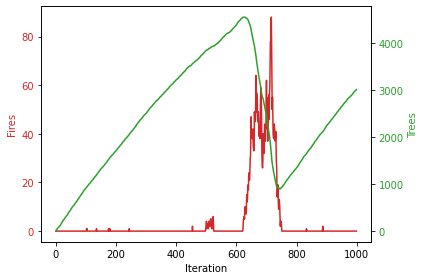

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Fires', color=color)
ax1.plot(series_fires, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.set_ylabel('Trees', color=color)  # we already handled the x-label with ax1
ax2.plot(series_trees, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### 2.5.2) Generating parameters from the time series

In [ ]:
N_fires, E_av, P_av, T_av = extract_timeseries(series_fires)
print(f'Number of fires: {N_fires}')

Number of fires: 33


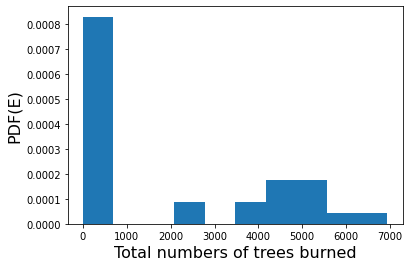

In [ ]:
plt.hist(E_av, density=True)
plt.xlabel('Total numbers of trees burned', size=16)
plt.ylabel('PDF(E)', size=16)
plt.show()

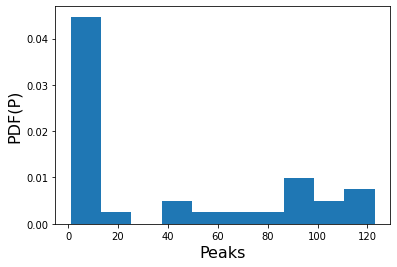

In [ ]:
plt.hist(P_av, density=True)
plt.xlabel('Peaks', size=16)
plt.ylabel('PDF(P)', size=16)
plt.show()

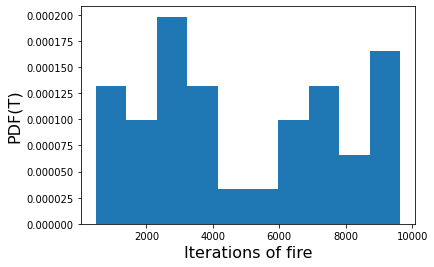

In [ ]:
plt.hist(T_av, density=True)
plt.xlabel('Iterations of fire', size=16)
plt.ylabel('PDF(T)', size=16)
plt.show()

# 3) OO Implementation

In [ ]:
class ForestFires:
  """Class that a Forest Fire simulation.
    
  Initial Parameters
  -----------------------------------------
  N(int): Size of the grid.
  time(int): Number of iterations.
  p_g(float): Probability of a tree growing.
  p_l(float): Probability of a lightning strikes a tree.
  stype(float): Stencil type for the neighbor connectivity. 
                Ex.: '6', '4', '8'. (default='8')  
  plotter(Boolean): If true plots a periodic update of trees and 
                    fires. (default=False)
  progress(Boolean): If true plots a progress bar of the simulation,
                     it does not work with the plotter at the same time.
                     (default=False)
  """
  
  def __init__(self, N, time, p_g, p_l, stype='8', plotter=False, progress=False):    
    
    self.N = N    
    self.dx, self.dy = self._stencil(stype=stype)
    self.grid = np.zeros((self.N+2,self.N+2), dtype='int')        
    
    self.trees = 0
    self.n_trees = []
    self.n_fires = []

    # Visualization Functions
    if plotter:
      self.plotter = PeriodicPlotter(sec=5, xlabel='Steps', ylabel='#')
    else:
      self.plotter = None

    self.progress = progress

    self._evolution(N, time, p_g, p_l)        

  def get_data(self):
    """Output the time series of trees and fires.

    """
    return n_trees, n_fires

  def plot(self):
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Fires', color=color)
    ax1.plot(self.n_fires, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:green'
    ax2.set_ylabel('Trees', color=color)  # we already handled the x-label with ax1
    ax2.plot(self.n_trees, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

  def _stencil(self, stype):
    """Creates the stencil for the Forest Fires."""
    if stype == '6':
      dx = np.array([1,0,1,-1,0,-1])
      dy = np.array([-1,-1,0,1,1,0])
    
    elif stype == '8': 
      dx = np.array([0,0,1,1,1,-1,-1,-1])
      dy = np.array([1,-1,-1,0,1,-1,0,1])
    
    elif stype == '4': 
      dx = np.array([0,0,1,-1])
      dy = np.array([1,-1,1,-1])


    else:
      raise Exception('Not a valid stencil type.')
  
    return dx, dy
    
  def _evolution(self, N, n_iter, p_g, p_l):
    """Evolution of the Forest Fires Model.

    """
    if self.progress:
      iterations = tqdm(range(n_iter))

    else:
      iterations = range(n_iter)

    for iterate in iterations:
      update = np.zeros([N+2, N+2], dtype='int')
      self.burn = 0

      for i in range(1, N+1):
        for j in range(1, N+1):
          
          # Check if there is a tree
          if self.grid[i,j] == 1:

            # Check if there is a burnin neighboring tree
            if 2 in self.grid[i + self.dx[:], j+ self.dy[:]]:
              update[i,j] = 1
              self.burn += 1

            # Check if there is a lightning strike
            if np.random.uniform() < p_l:
              update[i,j] = 1
              self.burn += 1

          # Remove burned trees
          if self.grid[i,j] == 2:
            update[i,j] -= 2
            self.trees -= 1
          
          # Check if a new tree grows        
          if self.grid[i,j] == 0:
            if np.random.uniform() < p_g:
              update[i,j] += 1
              self.trees += 1
        
      self.n_trees.append(self.trees)
      self.n_fires.append(self.burn)
      
      if self.plotter:
        self.plotter.plot([self.n_trees,self.n_fires])
      
      # Update the grid
      self.grid += update

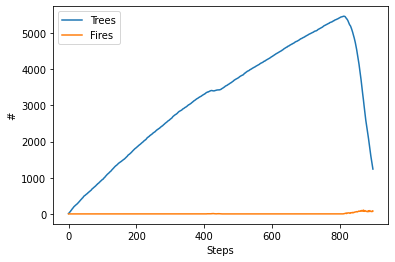

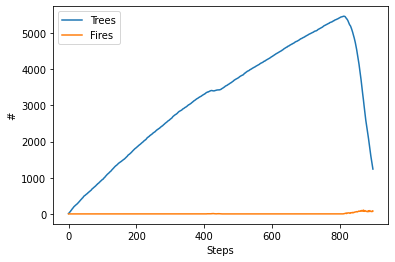

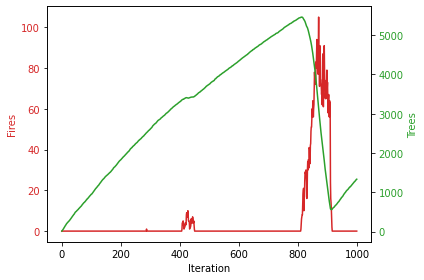

In [ ]:
N = 100
p_g = 1e-3
p_l = 1e-6
n_iter = int(1e3)

Test = ForestFires(N, n_iter, p_g, p_l, plotter=True)
Test.plot()